# Install and Import Libraries

In [1]:
!pip install torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Import the Relevant Packages**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn.utils import weight_norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np


# Load and Transform the MNIST Dataset
In PyTorch, we can download and load the MNIST dataset using the torchvision.datasets.MNIST class. By default, each image is in the range [0, 1] after applying transforms.ToTensor().

In [2]:
# Define a transform to convert PIL images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # converts [0,255] range to [0,1]
])

# Download and create datasets
train_dataset = datasets.MNIST(root='.', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root='.', train=False, download=True, transform=transform)

# Define data loaders to feed the data to the model during training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))


Number of training samples: 60000
Number of test samples: 10000


# Visualize Some Sample Images
Let's visualize the first ten images from the training set:

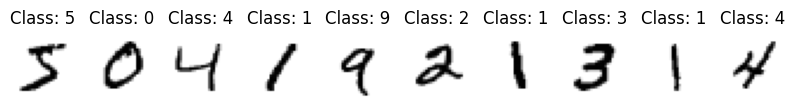

In [3]:
%matplotlib inline
pltsize=1
fig = plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    image, label = train_dataset[i]
    # image shape: [1, 28, 28] -> we take the first dimension to plot
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(image.numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(label))
plt.show()


# CNN Model in PyTorch

## Define the CNN Model in PyTorch

* Two convolutional layers (32 and 64 filters, each 3×3 kernel with padding=1), each followed by 2×2 max pooling.
* A fully connected hidden layer (nn.Linear) with 64 units and ReLU activation.
* A final fully connected layer of size 10 for the 10 classes (digits 0–9).
* We typically apply the softmax implicitly through CrossEntropyLoss.



In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1 input channel (grayscale), 32 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # After two 2x2 pooling operations on a 28x28 image -> 7x7
        # so total features before FC = 64 * 7 * 7
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPool
        x = F.relu(self.conv1(x))         # [batch_size, 32, 28, 28]
        x = F.max_pool2d(x, 2, 2)         # [batch_size, 32, 14, 14]

        # Conv2 + ReLU + MaxPool
        x = F.relu(self.conv2(x))         # [batch_size, 64, 14, 14]
        x = F.max_pool2d(x, 2, 2)         # [batch_size, 64,  7,  7]

        # Flatten
        x = x.view(x.size(0), -1)         # [batch_size, 64*7*7]

        # FC1 + ReLU
        x = F.relu(self.fc1(x))           # [batch_size, 64]

        # Output layer (the softmax will be handled by CrossEntropyLoss)
        x = self.fc2(x)                   # [batch_size, 10]

        return x


The number of convolutional layers can be **adjusted**, you can adjust the structure of the CNN in __init__, and redefine how the network performs forward transmission in forward. The following provides an example of increasing the amount of convolutional layers to 3.

In [4]:
class CNN(nn.Module):
    def __init__(self):
        # super(CNN, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)


        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Add conv3: 64 input channels, 128 output channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(in_features=128*3*3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))         # [batch_size, 32, 28, 28]
        x = F.max_pool2d(x, 2, 2)         # [batch_size, 32, 14, 14]

        x = F.relu(self.conv2(x))         # [batch_size, 64, 14, 14]
        x = F.max_pool2d(x, 2, 2)         # [batch_size, 64,  7,  7]

        # Add: Conv3 + ReLU + MaxPool
        x = F.relu(self.conv3(x))         # [batch_size, 128, 7, 7]
        x = F.max_pool2d(x, 2, 2)         # [batch_size, 128,  3,  3]

        # Flatten
        x = x.view(x.size(0), -1)         # [batch_size, 128*3*3]

        # FC1 + ReLU
        x = F.relu(self.fc1(x))           # [batch_size, 128]

        # Output layer (the softmax will be handled by CrossEntropyLoss)
        x = self.fc2(x)                   # [batch_size, 10]

        return x
    
    
   

## Print the CNN Model Structure


In [13]:
device = torch.device('cuda')
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Define the Loss Function and Optimizer

Use optim.RMSprop and nn.CrossEntropyLoss.

In [14]:
criterion = nn.CrossEntropyLoss()         # combines softmax + cross entropy
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

## Train the CNN Model

We train the model for 12 epochs. During each epoch, we:

1. Set the model to training mode (model.train()).
2.  Loop over the train_loader, compute the loss, do backpropagation, and update parameters.
3. Evaluate on the test set (used here as the validation set, as in your original example).
4. Track the best validation accuracy and save the model weights (model.weights.best.hdf5) whenever we see an improvement.

In [15]:
#Train
epochs = 12
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Create a progress bar for training data
    train_pbar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{epochs}] Training',
                     leave=False, ncols=100)

    # training loop
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Compute the loss
        loss = criterion(outputs, labels)

        # 4. Backpropagation
        loss.backward()

        # 5. Update parameters
        optimizer.step()

        # Accumulate the training loss
        running_loss += loss.item() * images.size(0)

        # Update the progress bar and display the loss
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate the average training loss
    epoch_training_loss = running_loss / len(train_loader.dataset)

    # evaluate the model
    model.eval()
    correct = 0
    running_val_loss = 0.0
    total = 0

    # Create a progress bar for test data
    test_pbar = tqdm(test_loader, desc=f'Epoch [{epoch+1}/{epochs}] Testing',
                    leave=False, ncols=100)

    with torch.no_grad():
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item() * images.size(0) # This line was incorrectly indented

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar and display the accuracy
            current_acc = 100.0 * correct / total
            test_pbar.set_postfix({'acc': f'{current_acc:.2f}%'})

    epoch_val_loss = running_val_loss / len(test_loader.dataset) # This line was incorrectly indented
    accuracy = 100.0 * correct / total
    # print epoch summary
    print(f"\nEpoch [{epoch+1}/{epochs}], Training Loss: {epoch_training_loss:.4f}, Evaluation Loss: {epoch_val_loss:.4f},  Test Accuracy: {accuracy:.2f}%")

    # save best model
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), 'model.weights.best.hdf5')
        print("  --> Model saved (Best accuracy so far)")

print(f"\nTraining completed! Best accuracy: {best_acc:.2f}%")


Epoch [1/12], Training Loss: 0.1046, Evaluation Loss: 0.1452,  Test Accuracy: 95.74%
  --> Model saved (Best accuracy so far)



Epoch [2/12], Training Loss: 0.1004, Evaluation Loss: 0.1518,  Test Accuracy: 95.71%


Epoch [3/12] Training:  97%|█████████████████████▍| 1822/1875 [00:10<00:00, 158.62it/s, loss=0.0239]

#Compare with the MLP model
To Compare the performance of MLP on the same dataset,you can refer to Practical 1：

## Define the MLP model in PyTorch



In [16]:
# MLP

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Using PyTorch version: 2.1.0+cu121
Using GPU, device name: NVIDIA GeForce RTX 4080 SUPER


## Define the train and test function

In [17]:
# count number of correct classification
def correct(output, target):
    predicted_digits = output.argmax(1)                # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                  # count number of correct ones

def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")



## Train the MLP model and show the test result

In [18]:
epochs = 12
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

test(test_loader, model, criterion)

Training epoch: 1
Average loss: 0.415297, accuracy: 88.83%
Training epoch: 2
Average loss: 0.229880, accuracy: 93.43%
Training epoch: 3
Average loss: 0.191627, accuracy: 94.47%
Training epoch: 4
Average loss: 0.168208, accuracy: 95.19%
Training epoch: 5
Average loss: 0.153250, accuracy: 95.55%
Training epoch: 6
Average loss: 0.142409, accuracy: 95.84%
Training epoch: 7
Average loss: 0.134119, accuracy: 96.03%
Training epoch: 8
Average loss: 0.126296, accuracy: 96.24%
Training epoch: 9
Average loss: 0.120594, accuracy: 96.46%
Training epoch: 10
Average loss: 0.116355, accuracy: 96.54%
Training epoch: 11
Average loss: 0.111793, accuracy: 96.78%
Training epoch: 12
Average loss: 0.107661, accuracy: 96.77%
Testset accuracy: 95.6%, average loss: 0.152534


# Overfitting


**Overfitting** occurs when the model learns the training data too well, including its noise and irrelevant details, to the extent that it performs poorly on unseen or test data.

## Regularisation

Regularization techniques help improve a neural network’s generalization ability by reducing overfitting. Common regularization techniques are as follows:



*   **L1 Regularization:** Penalizes the absolute values of weights, encouraging sparsity (some weights become 0).
*   **L2 Regularization:** Penalizes the squared values of weights, preventing large weights.







In [ ]:
#l1_loss = l1_reg * lambda_l1
#l2_loss = l2_reg * lambda_l2
#lambda_l1 = 0.00001  # L1 regularization parameter
#lambda_l2 = 0.00001  # L2 regularization parameter
def get_l1_regularization(model):
    l1_reg = 0
    for param in model.parameters():
        l1_reg += torch.sum(torch.abs(param))
    return l1_reg

def get_l2_regularization(model):
    l2_reg = 0
    for param in model.parameters():
        l2_reg += torch.sum(torch.pow(param, 2))
    return l2_reg

#add l1_loss and l2_loss
#total_loss = loss + l1_loss + l2_loss


Parameters of L1 regularization and L2 regularization control the strength of the L1 penalty applied to the model's weights. Setting these parameters correctly is crucial, as it determines the balance between underfitting and overfitting.


*   **Small values** (e.g., 0.0001): Apply a weak penalty, allowing the model to learn more complex patterns but with a higher risk of overfitting.
*   **Large values** (e.g., 0.1 or 1.0): Apply a strong penalty, encouraging sparsity (more weights become zero), but with a higher risk of underfitting.

Test the value of parameter from small value.



In [ ]:
lambda_l1 = 0.0001  # L1 regularization parameter()
lambda_l2 = 0.0001  # L2 regularization parameter
epochs = 12
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Compute the loss
        loss = criterion(outputs, labels)

        #Add l1/l2 loss
        l1_loss = lambda_l1 * get_l1_regularization(model)
        l2_loss = lambda_l2 * get_l2_regularization(model)

        #total loss
        loss = loss + l1_loss + l2_loss

        # 4. Backpropagation
        loss.backward()

        # 5. Update parameters
        optimizer.step()

        # Accumulate the training loss
        running_loss += loss.item() * images.size(0)

    # Compute average training loss over an epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    # Save the model if the test accuracy is the best we've seen so far
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), 'model.weights.best.hdf5')
        print("  --> Model saved.")

## Early Stopping
Early Stopping is a training strategy that prevents overfitting by monitoring the performance of the validation set to determine when to stop training.



#### Define the earlystopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True):
        """
        patience: How many epochs did not improve after which training will be stopped
        min_delta: The minimum result can be considered as improvement
        verbose: Whether to print earlystoppping information
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

#### Initialize EarlyStopping

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=True)
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

#### Train with Earlystopping

In [ ]:
epochs = 30
best_acc = 0.0
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    train_pbar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{epochs}] Training',
                     leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    test_pbar = tqdm(test_loader, desc=f'Epoch [{epoch+1}/{epochs}] Testing',
                    leave=False, ncols=100)

    with torch.no_grad():
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            current_acc = 100.0 * correct / total
            test_pbar.set_postfix({'acc': f'{current_acc:.2f}%'})

    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(accuracy)

    # print epoch summary
    print(f"\nEpoch [{epoch+1}/{epochs}]")
    print(f"Testset accuracy: {accuracy:.2f}%, Training loss: {epoch_train_loss:.4f}, , Evaluation loss: {epoch_val_loss:.4f}")

    # Save the best model
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), 'model.weights.best.hdf5')
        print("  --> Model saved (Best accuracy so far)")

    # Early Stopping checking
    early_stopping(epoch_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print(f"\nTraining completed! Best accuracy: {best_acc:.2f}%")


Epoch [1/30]
Testset accuracy: 98.18%, Training loss: 0.1528, , Evaluation loss: 0.0578
  --> Model saved (Best accuracy so far)



Epoch [2/30]
Testset accuracy: 98.95%, Training loss: 0.0454, , Evaluation loss: 0.0365
  --> Model saved (Best accuracy so far)



Epoch [3/30]
Testset accuracy: 99.05%, Training loss: 0.0317, , Evaluation loss: 0.0276
  --> Model saved (Best accuracy so far)



Epoch [4/30]
Testset accuracy: 99.24%, Training loss: 0.0240, , Evaluation loss: 0.0267
  --> Model saved (Best accuracy so far)



Epoch [5/30]
Testset accuracy: 99.12%, Training loss: 0.0198, , Evaluation loss: 0.0246



Epoch [6/30]
Testset accuracy: 99.08%, Training loss: 0.0155, , Evaluation loss: 0.0324
EarlyStopping counter: 1 out of 5



Epoch [7/30]
Testset accuracy: 99.04%, Training loss: 0.0133, , Evaluation loss: 0.0367
EarlyStopping counter: 2 out of 5



Epoch [8/30]
Testset accuracy: 99.16%, Training loss: 0.0118, , Evaluation loss: 0.0315
EarlyStopping counter: 3 out of 5



Epoch [9/30]
Testset accuracy: 99.24%, Training loss: 0.0097, , Evaluation loss: 0.0316
EarlyStopping counter: 4 out of 5



Epoch [10/30]
Testset accuracy: 99.17%, Training loss: 0.0074, , Evaluation loss: 0.0381
EarlyStopping counter: 5 out of 5
Early stopping triggered

Training completed! Best accuracy: 99.24%


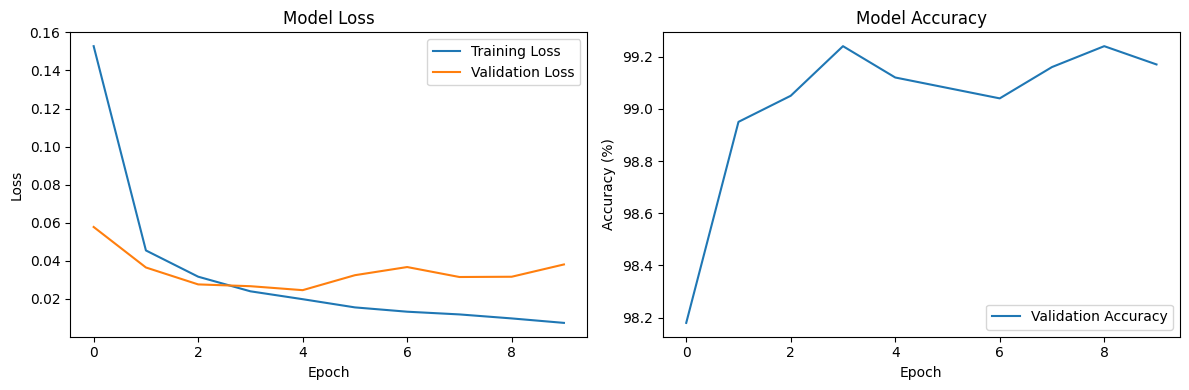

In [ ]:
# Display the training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)